In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchtsmixer import TSMixer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.training import train_tsmixer,train_latent_tsmixer,run_trials

#add a path to the system path
import sys
sys.path.append('../')

from experiments.datasets import *
seed=42
torch.manual_seed(seed)

In [2]:
sequence_length = 1
prediction_length = 20
input_channels = 4
output_channels = 1
n_samples=100
n_timesteps=prediction_length


#generate a Tumor dataset
args={
'n_samples': n_samples,'n_time_steps': n_timesteps,'time_horizon': 1.0,'noise_std': 0.0,'seed': 0,'equation': 'wilkerson'
}

Dataset_generator=SyntheticTumorDataset(**args)

X,ts,ys=Dataset_generator.get_X_ts_ys()

Ys=np.array(ys)
X_torch=torch.tensor(X.values).float().reshape(n_samples,sequence_length,input_channels)
Y_torch=torch.tensor(Ys).float().reshape(n_samples,prediction_length,1)
print(X_torch.shape,Y_torch.shape)

torch.Size([100, 1, 4]) torch.Size([100, 20, 1])


100%|██████████| 200/200 [00:02<00:00, 91.34it/s]


Best Model Test Loss: 0.0088, Best Epoch: 108


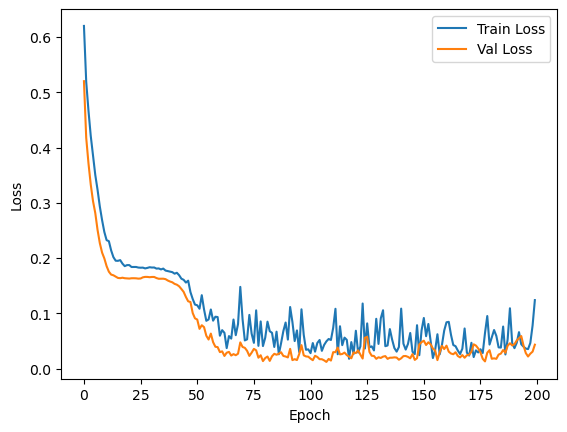

In [9]:
model= TSMixer(
    sequence_length=sequence_length,
    prediction_length=prediction_length,
    input_channels=input_channels,
    output_channels=output_channels,
)

best_model, curves, test_loss,test_dataset  = train_tsmixer(
    model,
    X_torch,
    Y_torch,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    epochs=200,
    batch_size=16,
    lr=1e-2,
    device="cpu"  # or "cpu"
)

plt.plot(curves[0], label='Train Loss')
plt.plot(curves[1], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

c:\Users\nicolas.i.fierro\AppData\Local\anaconda3\envs\timeview\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(20, 9)


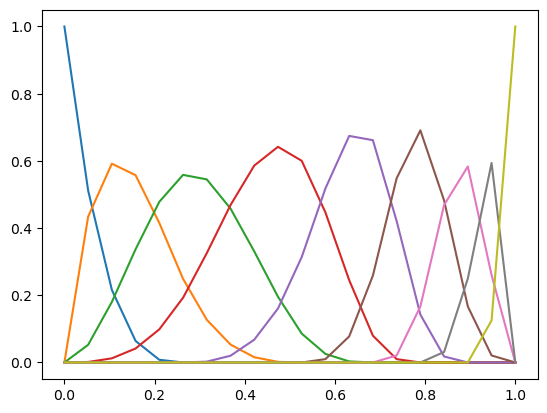

100%|██████████| 200/200 [00:03<00:00, 64.34it/s]


Best Model Test Loss: 0.0165, Best Epoch: 200


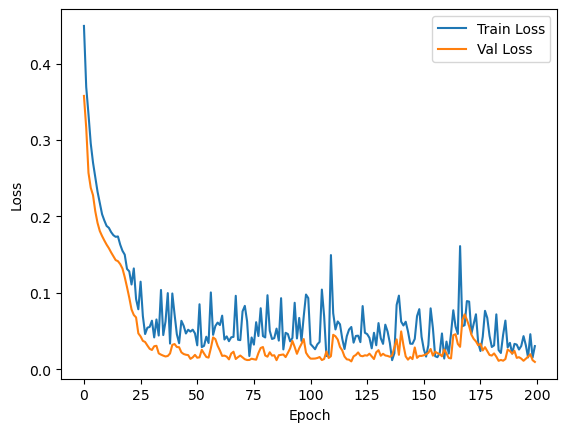

In [11]:
from timeview.basis import BSplineBasis
from timeview.knot_selection import calculate_knot_placement
B=9
t=ts[0]

internal_knots=calculate_knot_placement(ts, ys, n_internal_knots=B-2, T=1.0, seed=0, verbose=False)

bspline=BSplineBasis(n_basis=B,t_range=(t[0],t[-1]),internal_knots=internal_knots)

Phis = list(bspline.get_all_matrices(np.array(ts))) # (D, sequence_length, B)
print(Phis[0].shape)
for i in range(B):
    plt.plot(t,Phis[0][:,i])
plt.show()

latent_model = TSMixer(
    sequence_length=sequence_length,   # same as time steps in X
    prediction_length=B, # number of spline coefficients to predict
    input_channels=input_channels,
    output_channels=output_channels,
)

best_latent_model, curves, test_loss,test_dataset = train_latent_tsmixer(
    latent_model,
    X_torch,
    Y_torch,
    Phis=Phis,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    epochs=200,
    batch_size=16,
    lr=0.01,
    device="cpu"  # or "cuda"
)

plt.plot(curves[0], label='Train Loss')
plt.plot(curves[1], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

C:\Users\nicolas.i.fierro\AppData\Local\Temp\ipykernel_22356\1823027805.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  y_pred=torch.matmul(torch.Tensor(Phis)[0],h_pred).flatten().detach().numpy()


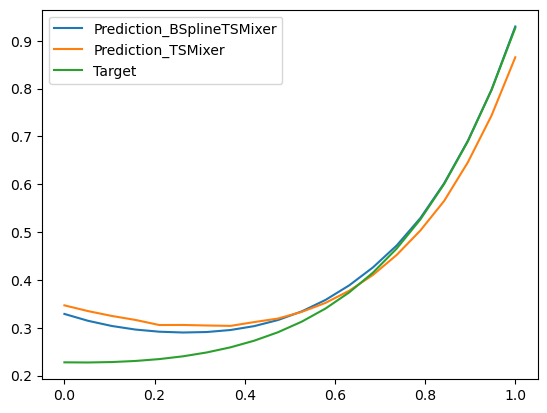

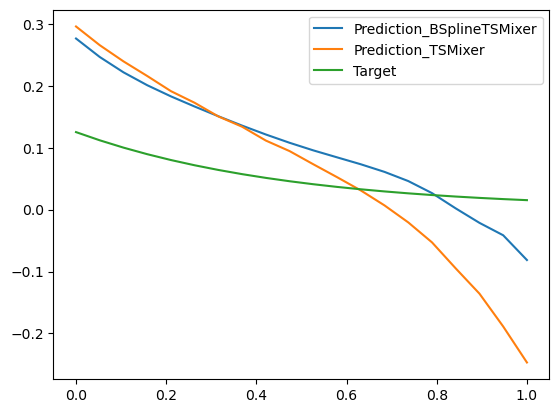

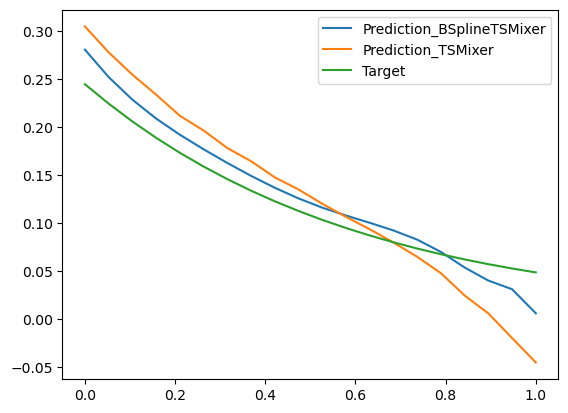

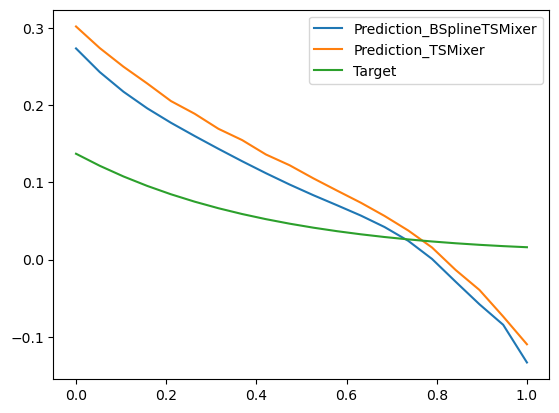

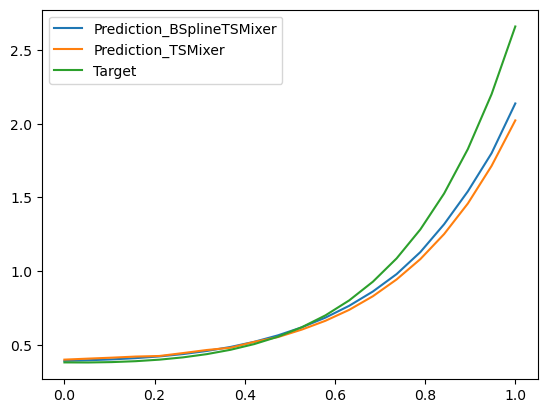

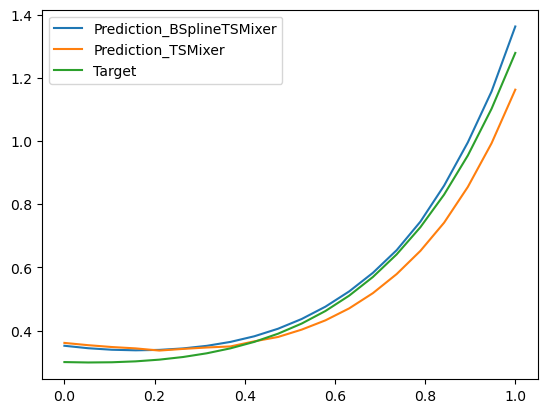

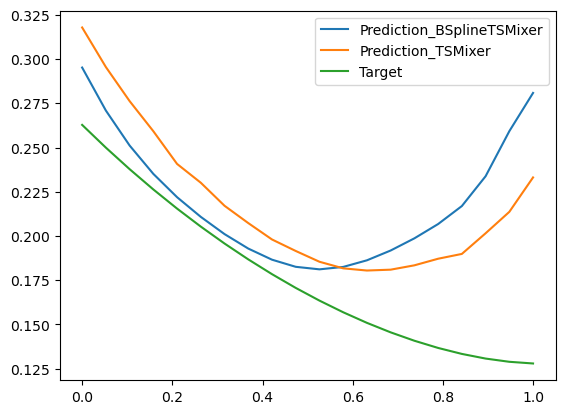

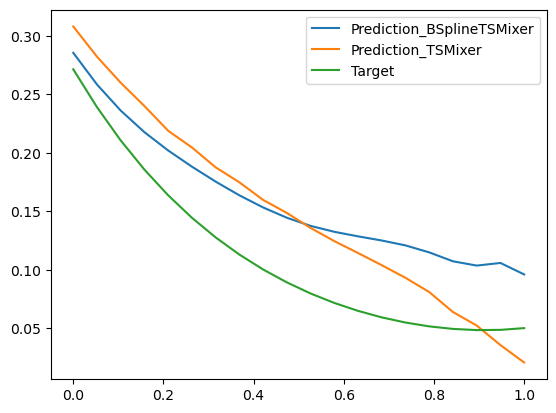

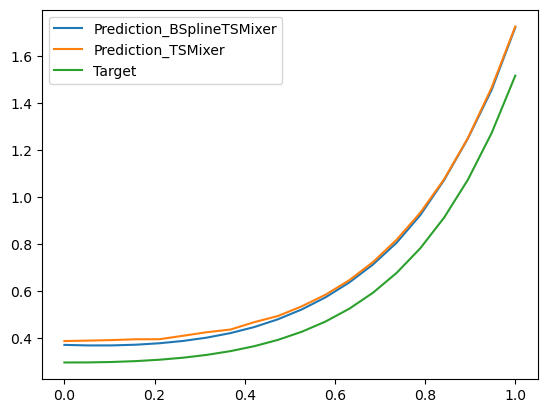

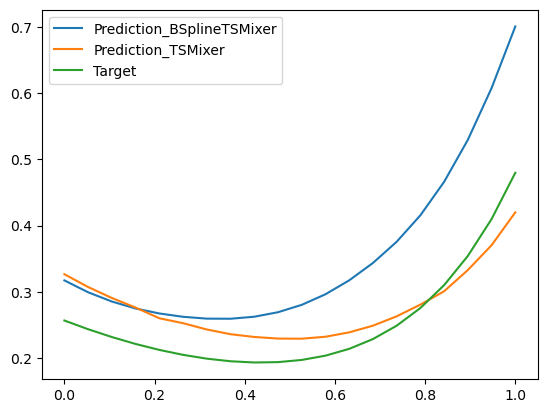

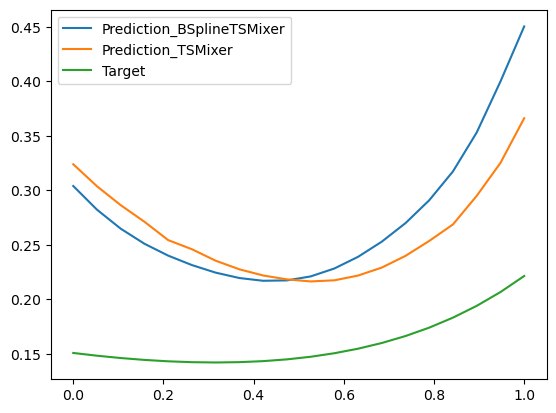

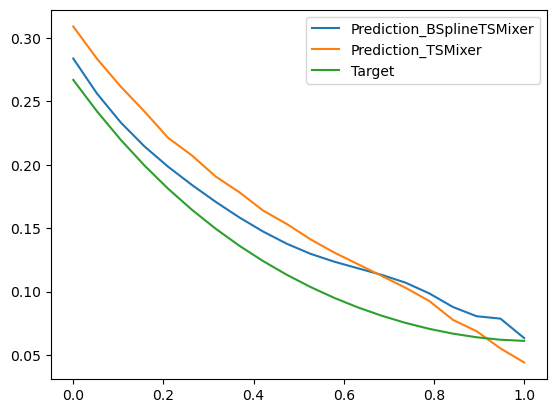

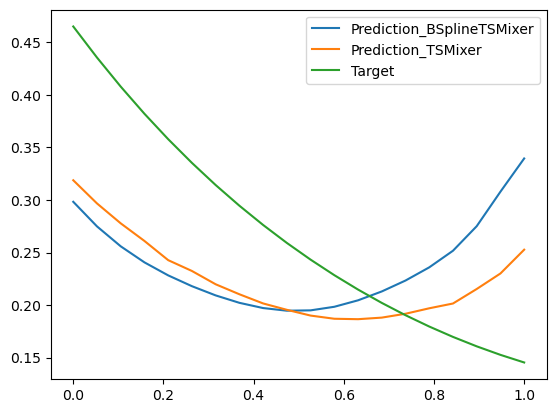

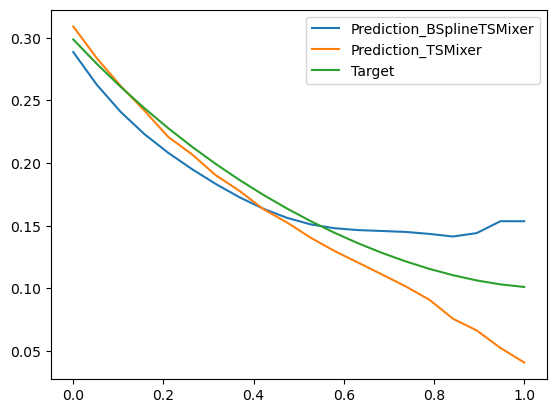

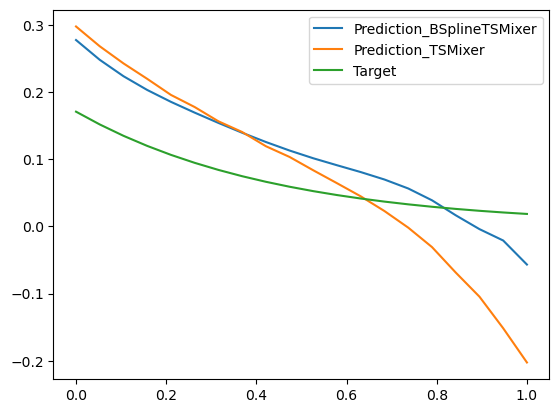

In [10]:
for idx in range(15):
    x_example=test_dataset.__getitem__(idx)[0]
    y_example=test_dataset.__getitem__(idx)[1]

    best_latent_model.eval()
    with torch.no_grad():
        h_pred = latent_model(x_example.unsqueeze(0))
    y_pred=torch.matmul(torch.Tensor(Phis)[0],h_pred).flatten().detach().numpy()

    best_model.eval()
    with torch.no_grad():
        pred = best_model(x_example.unsqueeze(0))

    plt.plot(ts[0],y_pred,label='Prediction_BSplineTSMixer')
    plt.plot(ts[0], pred.squeeze().numpy(), label='Prediction_TSMixer')
    plt.plot(ts[0], y_example.squeeze().numpy(), label='Target')
    plt.legend()
    plt.show()

In [6]:
df = pd.read_csv('../experiments/data/airfoil/airfoil_self_noise.dat', sep='\t', header=None)
df

,0,1,2,3,4,5
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [7]:
os.chdir('../experiments')
AirfoilDataset().get_X_ts_ys()


(     angle   chord  velocity  thickness
 0      0.0  0.3048      71.3   0.002663
 1      0.0  0.3048      55.5   0.002831
 2      0.0  0.3048      39.6   0.003101
 3      0.0  0.3048      31.7   0.003313
 4      1.5  0.3048      71.3   0.003367
 ..     ...     ...       ...        ...
 101   12.3  0.1016      55.5   0.036823
 102   12.3  0.1016      39.6   0.040827
 103   12.3  0.1016      31.7   0.041876
 104   15.6  0.1016      71.3   0.043726
 105   15.6  0.1016      39.6   0.052849
 
 [106 rows x 4 columns],
 [array([0.04  , 0.05  , 0.0625, 0.08  , 0.1   , 0.125 , 0.1575, 0.2   ,
         0.25  , 0.315 , 0.4   , 0.5   , 0.625 , 0.8   ]),
  array([0.025 , 0.0315, 0.04  , 0.05  , 0.0625, 0.08  , 0.1   , 0.125 ,
         0.1575, 0.2   , 0.25  , 0.315 , 0.4   , 0.5   , 0.625 ]),
  array([0.01   , 0.0125 , 0.01575, 0.02   , 0.025  , 0.0315 , 0.04   ,
         0.05   , 0.0625 , 0.08   , 0.1    , 0.125  , 0.1575 , 0.2    ,
         0.25   , 0.315  , 0.4    , 0.5    , 0.625  ]),
  array([